##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep & Cross Network (DCN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/recommenders/examples/dcn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/dcn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/recommenders/blob/main/docs/examples/dcn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/recommenders/docs/examples/dcn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to use Deep & Cross Network (DCN) to effectively learn feature crosses.

##Background

**What are feature crosses and why are they important?** Imagine that we are building a recommender system to sell a blender to customers. Then, a customer's past purchase history such as `purchased_bananas` and `purchased_cooking_books`, or geographic features, are single features. If one has purchased both bananas **and** cooking books, then this customer will more likely click on the recommended blender. The combination of `purchased_bananas` and `purchased_cooking_books` is referred to as a **feature cross**, which provides additional interaction information beyond the individual features.
<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1e8pYZHM1ZSwqBLYVkKDoGg0_2t2UPc2y" width="600"/>
</center>
</div>




**What are the challenges in learning feature crosses?** In Web-scale applications, data are mostly categorical, leading to large and sparse feature space. Identifying effective feature crosses in this setting often requires
manual feature engineering or exhaustive search. Traditional feed-forward multilayer perceptron (MLP) models are universal function approximators; however, they cannot efficiently approximate even 2nd or 3rd-order feature crosses [[1](https://arxiv.org/pdf/2008.13535.pdf), [2](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/18fa88ad519f25dc4860567e19ab00beff3f01cb.pdf)].

**What is Deep & Cross Network (DCN)?** DCN was designed to learn explicit and bounded-degree cross features more effectively. It starts with an input layer (typically an embedding layer), followed by a *cross network* containing multiple cross layers that models explicit feature interactions, and then combines
with a *deep network* that models implicit feature interactions.


*   Cross Network. This is the core of DCN. It explicitly applies feature crossing at each layer, and the highest
polynomial degree increases with layer depth. The following figure shows the $(i+1)$-th cross layer.
<div class="fig figcenter fighighlight">
<center>
  <img src="http://drive.google.com/uc?export=view&id=1QvIDptMxixFNp6P4bBqMN4AYAhAIAYQZ" width="50%" style="display:block">
  </center>
</div>
*   Deep Network. It is a traditional feedforward multilayer perceptron (MLP).

The deep network and cross network are then combined to form DCN [[1](https://arxiv.org/pdf/2008.13535.pdf)]. Commonly, we could stack a deep network on top of the cross network (stacked structure); we could also place them in parallel (parallel structure). 


<div class="fig figcenter fighighlight">
<center>
  <img src="http://drive.google.com/uc?export=view&id=1WtDUCV6b-eetUnWVCAmcPh8mJFut5EUd" hspace="40" width="30%" style="margin: 0px 100px 0px 0px;">
  <img src="http://drive.google.com/uc?export=view&id=1xo_twKb847hasfss7JxF0UtFX_rEb4nt" width="20%">
  </center>
</div>

In the following, we will first show the advantage of DCN with a toy example, and then we will walk you through some common ways to utilize DCN using the MovieLen-1M dataset.

Let's first install and import the necessary packages for this colab.


In [2]:
# !pip install -q tensorflow-recommenders
# !pip install -q --upgrade tensorflow-datasets

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs
from icecream import ic

## Toy Example
To illustrate the benefits of DCN, let's work through a simple example. Suppose we have a dataset where we're trying to model the likelihood of a customer clicking on a blender Ad, with its features and label described as follows.

| Features / Label        | Description           | Value Type / Range  |
| ------------- |-------------| -----|
| $x_1$ = country | the country this customer lives in | Int in [0, 199] |
| $x_2$ = bananas | # bananas the customer has purchased |Int in   [0, 23] |
| $x_3$ = cookbooks | # cooking books the customer has purchased     |Int in  [0, 5] |
| $y$ | the likelihood of clicking on a blender Ad     |   -- |

Then, we let the data follow the following underlying distribution:
$$y = f(x_1, x_2, x_3) = 0.1x_1 + 0.4x_2+0.7x_3 + 0.1x_1x_2+3.1x_2x_3+0.1x_3^2$$

where the likelihood $y$ depends linearly both on features $x_i$'s, but also on multiplicative interactions between the $x_i$'s. In our case, we would say that the likelihood of purchasing a blender ($y$) depends not just on buying bananas ($x_2$) or cookbooks ($x_3$), but also on buying bananas and cookbooks *together* ($x_2x_3$).

We can generate the data for this as follows:


### Synthetic data generation

We first define $f(x_1, x_2, x_3)$ as described above. 

In [4]:
def get_mixer_data(data_size=100_000, random_seed=42):
  # We need to fix the random seed
  # to make colab runs repeatable.
  rng = np.random.RandomState(random_seed)
  country = rng.randint(200, size=[data_size, 1]) / 200.
  bananas = rng.randint(24, size=[data_size, 1]) / 24.
  coockbooks = rng.randint(6, size=[data_size, 1]) / 6.

  x = np.concatenate([country, bananas, coockbooks], axis=1)

  # # Create 1st-order terms.
  y = 0.1 * country + 0.4 * bananas + 0.7 * coockbooks

  # Create 2nd-order cross terms.
  y += 0.1 * country * bananas + 3.1 * bananas * coockbooks + (
        0.1 * coockbooks * coockbooks)

  return x, y

Let's generate the data that follows the distribution, and split the data into 90% for training and 10% for testing.

In [5]:
x, y = get_mixer_data()
num_train = 90000
train_x = x[:num_train]
train_y = y[:num_train]
eval_x = x[num_train:]
eval_y = y[num_train:]

### Model construction

We're going to try out both cross network and deep network to illustrate the advantage a cross network can bring to recommenders. As the data we just created only contains 2nd-order feature interactions, it would be sufficient to illustrate with a single-layered cross network. If we wanted to model higher-order feature interactions, we could stack multiple cross layers and use a multi-layered cross network. The two models we will be building are:
1.   Cross Network with only one cross layer;
2.   Deep Network with wider and deeper ReLU layers. 

We first build a unified model class whose loss is the mean squared error. 

In [6]:
class Model(tfrs.Model):

  def __init__(self, model):
    super().__init__()
    self._model = model
    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[
        tf.keras.metrics.RootMeanSquaredError("RMSE")
      ]
    )

  def call(self, x):
    ic(x.shape)
    x = self._model(x)
    ic(x)
    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    x, labels = features
    scores = self(x)

    return self.task(
        labels=labels,
        predictions=scores,
    )

Then, we specify the cross network (with 1 cross layer of size 3) and the ReLU-based DNN (with layer sizes [512, 256, 128]):

In [7]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
      tf.keras.layers.Dense(512, activation="relu"),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu")
    ])
)

### Model training
Now that we have the data and models ready, we are going to train the models. We first shuffle and batch the data to prepare for model training.


In [8]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((eval_x, eval_y)).batch(1000)

Then, we define the number of epochs as well as the learning rate.

In [9]:
epochs = 100
learning_rate = 0.4

Alright, everything is ready now and let's compile and train the models. You could set `verbose=True` if you want to see how the model progresses.

In [10]:
crossnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate), run_eagerly=True)
crossnet.fit(train_data, epochs=epochs, verbose=False)

Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL 

In [ ]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

### Model evaluation
We verify the model performance on the evaluation dataset and report the Root Mean Squared Error (RMSE, the lower the better).

In [ ]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0065 using 16 parameters.
DeepNet(large) RMSE is 0.1231 using 166401 parameters.


We see that the cross network achieved **magnitudes lower RMSE** than a ReLU-based DNN, with **magnitudes fewer parameters**. This has suggested the efficieny of a cross network in learning feaure crosses.  

### Model understanding
We already know what feature crosses are important in our data, it would be fun to check whether our model has indeed learned the important feature cross. This can be done by visualizing the learned weight matrix in DCN. The weight $W_{ij}$ represents the learned importance of interaction between feature $x_i$ and $x_j$.

/home/huigecheng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/huigecheng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


<Figure size 648x648 with 0 Axes>

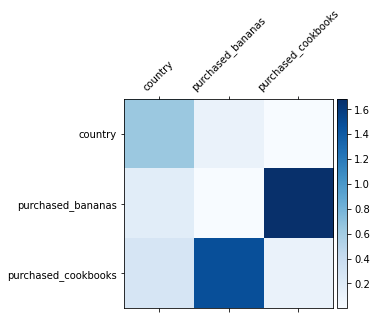

In [ ]:
mat = crossnet._model._dense.kernel
ic(mat.shape)
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

Darker colours represent stronger learned interactions - in this case, it's clear that the model learned that purchasing babanas and cookbooks together is important.

If you are interested in trying out more complicated synthetic data, feel free to check out [this paper](https://arxiv.org/pdf/2008.13535.pdf).

## Movielens 1M example
We now examine the effectiveness of DCN on a real-world dataset: Movielens 1M [[3](https://grouplens.org/datasets/movielens)]. Movielens 1M is a popular dataset for recommendation research. It predicts users' movie ratings given user-related features and movie-related features. We use this dataset to domenstrate some common ways to utilize DCN.

### Data processing

The data processing procedure follows a similar procedure as the [basic ranking tutorial](https://www.tensorflow.org/recommenders/examples/basic_ranking).

In [ ]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling movie_lens-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movie_lens downloaded and prepared to /home/huigecheng/tensorflow_datasets/movie_lens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Next, we randomly split the data into 80% for training and 20% for testing.


In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Then, we create vocabulary for each feature.

In [ ]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

### Model construction

The model architecture we will be building starts with an embedding layer, which is fed into a cross network followed by a deep network. The embedding dimension is set to 32 for all the features. You could also use different embedding sizes for different features.

In [ ]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      
    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.experimental.preprocessing.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)
    ic(x.shape)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)
      ic(x.shape)
    
    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)
      ic(x.shape)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

### Model training
We shuffle, batch and cache the training and test data. 


In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Let's define a function that runs a model multiple times and returns the model's RMSE mean and standard deviation out of multiple runs.

In [ ]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), run_eagerly=True)
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

We set some hyper-parameters for the models. Note that these hyper-parameters are set globally for all the models for demonstration purpose. If you want to obtain the best performance for each model, or conduct a fair comparison among models, then we'd suggest you to fine-tune the hyper-parameters. Remember that the model architecture and optimization schemes are intertwined.

In [ ]:
epochs = 8
learning_rate = 0.01

**DCN (stacked).** We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.
<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1X8qoMtIYKJz4yBYifvfw4QpAwrjr70e_" width="140"/>
</center>
</div>


In [ ]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

ic| x.shape: TensorShape([8192, 192])
ic| x.shape: TensorShape([8192, 192])
ic| x.shape: TensorShape([8192, 192])
ic| x.shape: TensorShape([8192, 192])
ic| x.shape: TensorShape([8192, 192])
ic| x.shape: TensorShape([8192, 192])

**Low-rank DCN.** To reduce the training and serving cost, we leverage low-rank techniques to approximate the DCN weight matrices. The rank is passed in through argument `projection_dim`; a smaller `projection_dim` results in a lower cost. Note that `projection_dim` needs to be smaller than (input size)/2 to reduce the cost. In practice, we've observed using low-rank DCN with rank (input size)/4 consistently preserved the accuracy of a full-rank DCN.

<div>
<center>
<img src="http://drive.google.com/uc?export=view&id=1ZZfUTNdxjGAaAuwNrweKkLJ1PGxMmiCm" width="400"/>
</center>
</div>


In [ ]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

**DNN.** We train a same-sized DNN model as a reference.

In [ ]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

We evaluate the model on test data and report the mean and standard deviation out of 5 runs.

In [ ]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))


We see that DCN achieved better performance than a same-sized DNN with ReLU layers. Moreover, the low-rank DCN was able to reduce parameters while maintaining the accuracy.

**More on DCN.** Besides what've been demonstrated above, there are more creative yet practically useful ways to utilize DCN [[1](https://arxiv.org/pdf/2008.13535.pdf)]. 

*   *DCN with a parallel structure*.  The inputs are fed in parallel to a cross network and a deep network.

*   *Concatenating cross layers.* The inputs are fed in parallel to multiple cross layers to capture complementary feature crosses.

<div class="fig figcenter fighighlight">
<center>
  <img src="http://drive.google.com/uc?export=view&id=11RpNuj9s0OgSav9TUuGA7v7PuFLL6nVR" hspace=40 width="600" style="display:block;">
  <div class="figcaption">
  <b>Left</b>: DCN with a parallel structure; <b>Right</b>: Concatenating cross layers. 
  </div>
  </center>
</div>

### Model understanding

The weight matrix $W$ in DCN reveals what feature crosses the model has learned to be important. Recall that in the previous toy example, the importance of interactions between the $i$-th and $j$-th features is captured by the ($i, j$)-th element of $W$.

What's a bit different here is that the feature embeddings are of size 32 instead of size 1. Hence, the importance will be characterized by the $(i, j)$-th block
$W_{i,j}$ which is of dimension 32 by 32.
In the following, we visualize the Frobenius norm [[4](https://en.wikipedia.org/wiki/Matrix_norm)] $||W_{i,j}||_F$ of each block, and a larger norm would suggest higher importance (assuming the features' embeddings are of similar scales).

Besides block norm, we could also visualize the entire matrix, or the mean/median/max value of each block.

In [ ]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

That's all for this colab! We hope that you have enjoyed learning some basics of DCN and common ways to utilize it. If you are interested in learning more, you could check out two relevant papers: [DCN-v1-paper](https://arxiv.org/pdf/1708.05123.pdf), [DCN-v2-paper](https://arxiv.org/pdf/2008.13535.pdf).

---


##References
[DCN V2: Improved Deep & Cross Network and Practical Lessons for Web-scale Learning to Rank Systems](https://arxiv.org/pdf/2008.13535.pdf). \
*Ruoxi Wang, Rakesh Shivanna, Derek Zhiyuan Cheng, Sagar Jain, Dong Lin, Lichan Hong, Ed Chi. (2020)*


[Deep & Cross Network for Ad Click Predictions](https://arxiv.org/pdf/1708.05123.pdf). \
*Ruoxi Wang, Bin Fu, Gang Fu, Mingliang Wang. (AdKDD 2017)*